# Physics-Informed Neural Networks

This code reproduces the work of [Raissi, Perdikaris, and Karniadakis on Physics-Informed Neural Networks](https://reader.elsevier.com/reader/sd/pii/S0021999118307125?token=EE37034F24809292F4D9BEB2A9B72D1DFDDF3A321BC7E6E4F7D8ACAF05957EC36B8F3B729C42386D42455EC9058777E5&originRegion=eu-west-1&originCreation=20211108164718), applied to Burgers' equation:

$$
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} - \frac{0.01}{\pi}\frac{\partial^2u}{\partial x^2} = 0
$$

With initial and boundary conditions:
$$
u(0,x) = -\sin(\pi x) \\
u(t,-1) = u(t,1) = 0
$$

In [1]:
from matplotlib import pyplot as plt

from jaxdf.geometry import Domain
from jax import numpy as jnp
import jax

In [2]:
domain = Domain(N=(200, 1000), dx=(0.01, 0.001)) # Domain is [space, time]

In [3]:
# Get samples for enforcing losses
domain_sampler = domain.domain_sampler
boundary_samples = domain.boundary_sampler

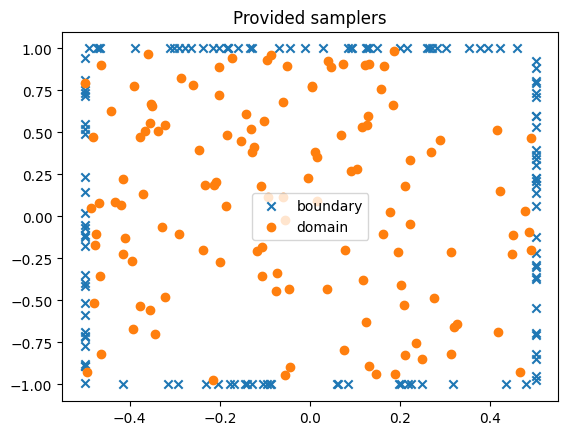

In [4]:
# Show example
boundary_sampler = domain.boundary_sampler
x = boundary_sampler(jax.random.PRNGKey(42), 128)
plt.scatter(x[:,1],x[:,0], marker='x', label="boundary")
x = domain_sampler(jax.random.PRNGKey(42), 128)
plt.scatter(x[:,1],x[:,0], marker='o', label="domain")
plt.legend()
plt.title("Provided samplers")
plt.show()

In [5]:
# Construct the PINN
from jaxdf.discretization import Continuous
from jax.example_libraries import stax
from jax import random

seed = random.PRNGKey(0)

# Make a neural network for the field discretization
Tanh = stax.elementwise(jnp.tanh)
Layers = [stax.Dense(20), Tanh]*9
init_random_params, predict_p = stax.serial(*Layers, stax.Dense(1))

def init_params(seed, domain):
    return init_random_params(seed, (len(domain.N),))[1]

def get_fun(params, x):
    return predict_p(params, x)

u = Continuous.from_function(domain, init_params, get_fun, seed)

In [6]:
u(jnp.asarray([0.,0.]))

Array([-0.0290687], dtype=float32)

In [7]:
def show_field(u):
    plt.figure(figsize=(15,4))
    plt.imshow(u.on_grid, cmap="RdBu", extent=[0,1,-1,1], vmin=-1., vmax=1., aspect='auto')
    plt.xlabel("$t$")
    plt.ylabel("$x$")
    plt.colorbar()
    plt.show()

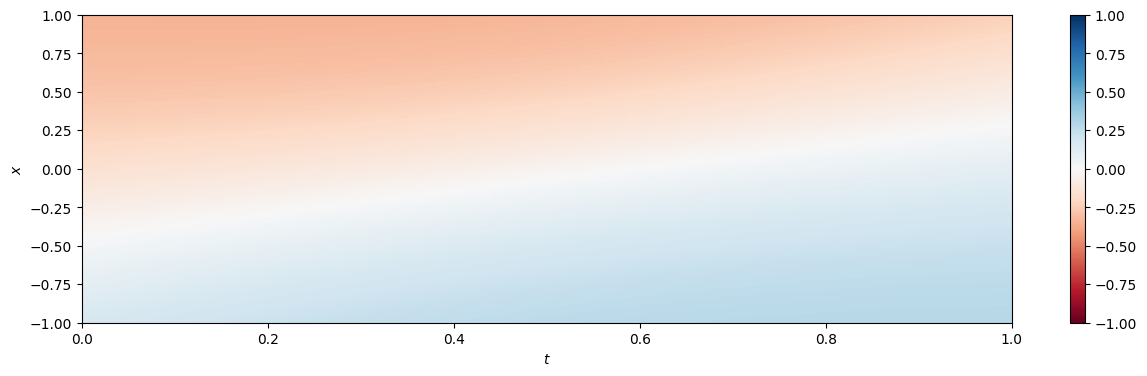

In [8]:
show_field(u)

In [9]:
from jaxdf.operators.differential import derivative

def burgers(u):
    du_dt = derivative(u, axis=1)
    du_dx = derivative(u, axis=0)
    ddu_dx = derivative(du_dx, axis=0)
    return (-0.01/jnp.pi)*ddu_dx + u*du_dx + du_dt

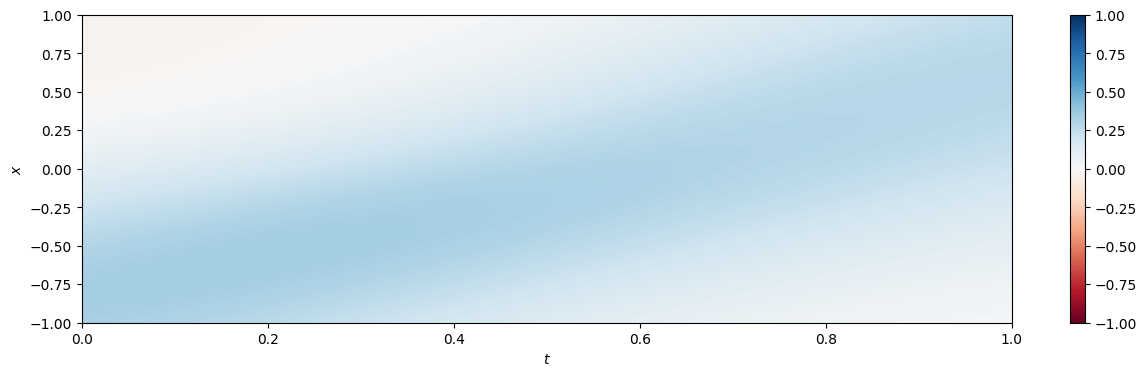

In [10]:
sample_burgers = burgers(u)
show_field(sample_burgers)

In [11]:
from functools import partial

batchsize = 256

@partial(jax.jit, static_argnums=2)
def boundary_loss(u, seed, batchsize):
    x = domain_sampler(seed, batchsize)
        
    # Initial conditions
    y = x.at[:,1].set(-0.5)
    
    # Can apply vmap on a wrapped function of the field
    @jax.vmap
    def field_fun(x):
        return u.get_field(x)
    
    field_val = field_fun(y)
    target_val = jnp.expand_dims(-jnp.sin(jnp.pi*x[:,0]), -1)
    
    l1 = jnp.mean(jnp.abs(target_val - field_val)**2)
    
    # Boundaries
    y = x.at[:,0].set(random.bernoulli(seed, shape=(batchsize,))*2 - 1)
    field_val = field_fun(y)
    target_val = 0
    l2 = jnp.mean(jnp.abs(target_val - field_val)**2)
    
    return (l1 + l2)/2


@partial(jax.jit, static_argnums=2)
def domain_loss(u, seed, batchsize):
    x = domain_sampler(seed, batchsize)
    
    @jax.vmap
    def residual_fun(x):
        return burgers(u)(x)
    
    residual = residual_fun(x)
    return jnp.mean(jnp.abs(residual)**2)

# Testing losses
bl = boundary_loss(u, seed, 32)
dl = domain_loss(u, seed, 32)

print(f"Domain loss: {dl.item()}, Boundary loss: {bl.item()}")

Domain loss: 0.0534413680434227, Boundary loss: 0.42259204387664795


In [12]:
@jax.jit
def update(opt_state, seed, k):
    seeds = random.split(seed, 2)
    
    def tot_loss(u):
        l1 = domain_loss(u, seeds[0], batchsize)
        l2 = boundary_loss(u, seeds[1], batchsize)
        return l1+l2
    
    lossval, grads = jax.value_and_grad(tot_loss)(get_params(opt_state))
    
    return lossval, update_fun(k, grads, opt_state)

In [13]:
from jax.example_libraries import optimizers

#Initial field
u = Continuous.from_function(domain, init_params, get_fun, seed)

init_fun, update_fun, get_params = optimizers.adam(.0001)
opt_state = init_fun(u)

In [14]:
from tqdm import tqdm

pbar = tqdm(range(100000))
rng = seed

for k in pbar:
    rng, seed = random.split(rng,2)
    lossval, opt_state = update(opt_state, seed, k)
    
    if k % 500 == 99:
        pbar.set_description(f"Loss: {lossval}")

Loss: 0.0016563150566071272: 100%|███████████████████████████████████████| 100000/100000 [02:58<00:00, 558.72it/s]


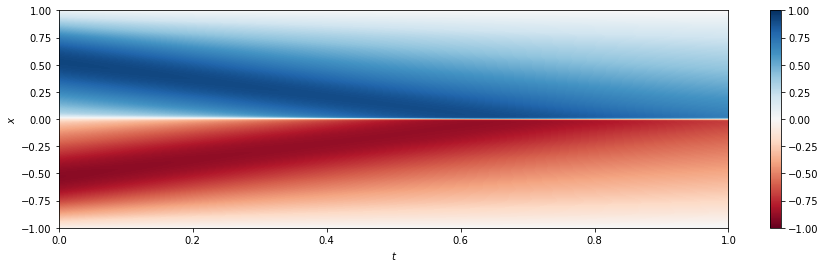

In [23]:
u = get_params(opt_state)

show_field(u)